In [1]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import skimage
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm, gaussian_kde

def ne_transform(deg):
    return((np.cos(np.deg2rad(deg))+1)/2)


In [2]:
####SUMMARY PLOT!####
#create map highlighting the spatial regions of differing elevation groups
#use cluster analysis?

BUCKETS = ['rio-mora','ikh-nart']
for BUCKET in BUCKETS:
    if BUCKET == 'ikh-nart':
        vmin = 0.1
        vmax = 0.35
        figsize = (20,12)
    else:
        vmin = 0.2
        vmax = 0.65
        figsize = (20,7)

    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/ndvi.tif')
    ndvi = tif.read()
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/srtm.tif')
    srtm = tif.read()


In [3]:
var = srtm[0].copy()

smoothed_rescale = rescale(gaussian_filter(var.copy(), sigma=2), 0.2, mode='reflect')
smoothed_rescale[np.isnan(smoothed_rescale)]=-1

X = np.reshape(smoothed_rescale, (-1,1))
connectivity = grid_to_graph(*smoothed_rescale.shape)

Compute structured hierarchical clustering...
Elapsed time:  7.59168004989624
Number of pixels:  93688
Number of clusters:  5


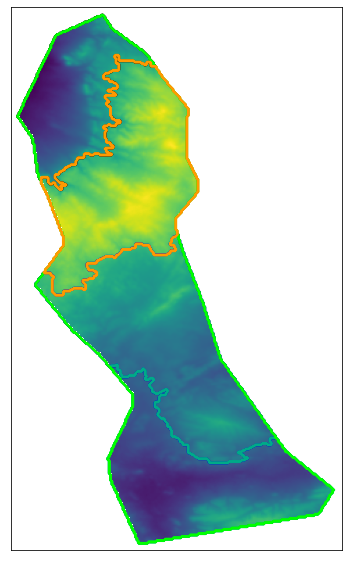

In [8]:
print("Compute structured hierarchical clustering...")
import time as time
st = time.time()
n_clusters = 5  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, smoothed_rescale.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)
img = smoothed_rescale.copy()
img[img==-1] = np.nan
# #############################################################################
# Plot the results on an image
plt.figure(figsize=(10, 10))
plt.imshow(img)
#plt.imshow(smoothed_rescale, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

array([0, 0, 0, ..., 0, 0, 0])

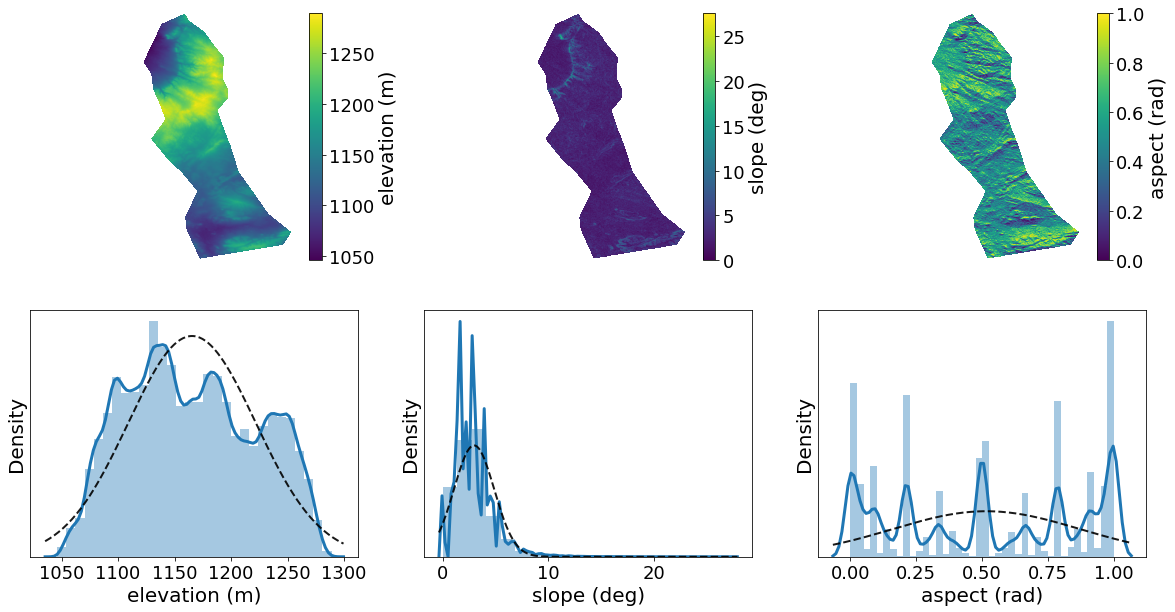

In [3]:
labels = ['elevation (m)', 'slope (deg)', 'aspect (rad)']
nbins = [30,20,40]
f, ax = plt.subplots(2,3,figsize=(20,10))
for i,d in enumerate(srtm):
    if i ==2:
        d = ne_transform(d)
    cmap = plt.cm.viridis
    im = ax[0,i].imshow(d, cmap=cmap)
    ax[0,i].axis('off')
    cbar = f.colorbar(im, ax=ax[0,i])
    cbar.ax.set_ylabel(labels[i], fontsize=20)
    cbar.ax.tick_params(labelsize=18) 
    #ax[1,i].hist(d.flatten(),bins=8)
    #kde_kws={'color':'blue','lw':1,'ls':'--','alpha':1},
   
    minbin, maxbin = np.nanmin(d), np.nanmax(d)
    bins = np.linspace(minbin, maxbin, nbins[i])
    cbins = (bins-bins.min())/(bins.max()-bins.min())
    hist, bin_edges = np.histogram(d, bins)
    colors = cmap(cbins)
    width = bins[1]-bins[0]
    #ax[1,i].bar(bin_edges[:-1], hist, width=width, color=colors)
    ax[1,i].set_xlabel(labels[i], fontsize=20)
    ax[1,i].set_yticks([])
    ax[1,i].set_ylabel('Density', fontsize=20)
    ax[1,i].tick_params(axis='both', labelsize=18)
    sns.distplot(d.flatten(), ax=ax[1,i], hist=True, bins=nbins[i],\
             kde=True, kde_kws={'lw':3},\
             fit=norm, fit_kws={'lw':2,'ls':'--',"alpha": 0.9, "color": "k"})


In [ ]:
from sklearn.neighbors import KernelDensity

d = srtm[0].copy()
minbin, maxbin = np.nanmin(d), np.nanmax(d)
d[np.isnan(d)]=0
bins = np.linspace(minbin, maxbin, nbins[i])
density = sum(norm(xi).pdf(bins) for xi in d.flatten())
hist, bin_edges = np.histogram(d, bins)
colors = cmap(cbins)
width = bins[1]-bins[0]
#kde = KernelDensity(bandwidth=width, kernel='gaussian')
#k = kde.fit(d.flatten())
#f, ax = plt.subplots(1,1)
#ax.bar(bin_edges[:-1], hist, width=width, color=colors, alpha=0.4)
#ax.plot(bins,kde(bins))

In [ ]:
plt.fill_between(bins, density)

In [ ]:
####SUMMARY PLOT!####

BUCKETS = ['rio-mora','ikh-nart']
for BUCKET in BUCKETS:
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/ndvi.tif')
    if BUCKET == 'ikh-nart':
        vmin = 0.1
        vmax = 0.35
        figsize = (20,12)
    else:
        vmin = 0.2
        vmax = 0.65
        figsize = (20,7)

    data = tif.read()
    years = np.arange(1986,2021) 
    max_year_i = np.argmax(np.nanmean(data,axis=(1,2)))
    min_year_i = np.argmin(np.nanmean(data,axis=(1,2)))
    decade_map = {'198':0, '199':1, '200':2, '201':3}

    ####GRIDSPEC PREP####
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = GridSpec(2, 5, wspace=0, hspace=0.05)
    rows, cols = 4,10
    gs0 = GridSpecFromSubplotSpec(rows, cols, wspace=0, hspace=0.05, subplot_spec=gs[:,:-2])

    row_group = []
    for k,v in decade_map.items():
        for y in years:
            if k in str(y):
                row_group.append(v)
    row_group = np.array(row_group)            

    col_group = []
    u,c = np.unique(row_group, return_counts=True)
    for j in c:
        col_group.append(np.arange(j))
    col_group = np.concatenate(col_group)

    ####NDVI PLOT####
    for i in range(len(data)-1):            
        r, c = row_group[i], col_group[i]
        ax = fig.add_subplot(gs0[r,c])   
        ax.axis('off')
        ax.imshow(data[i],vmin=vmin,vmax=vmax)
        ax.set_title(years[i],fontsize=18)

    ####LAST YEAR PLOT####
    gs1 = GridSpecFromSubplotSpec(3,4, wspace=0, hspace=0.05, subplot_spec=gs[:,-2:])
    ax = fig.add_subplot(gs1[:-1,:2])
    ax.axis('off')
    ax.imshow(data[-1],vmin=vmin,vmax=vmax)
    ax.set_title(years[-1],fontsize=18)

    ####TRUE COLOR PREP####
    if BUCKET == 'ikh-nart':
        gamma = .5 
    else:
        gamma = .8 
    tiffile = f'/datadrive/{BUCKET}/processed/peakcolor.tif'
    tif = rasterio.open(tiffile)

    selection =['B3','B2','B1']
    colors = [(i+1,b) for i,b in enumerate(tif.descriptions) \
              if any(s in b for s in selection)]

    scale = gamma/1800
    tc_data = []
    for year in years:
        year_color = [(i,a) for i,a in colors if str(year) in a]
        r = tif.read(year_color[0][0]).astype(np.float)*scale
        g = tif.read(year_color[1][0]).astype(np.float)*scale
        b = tif.read(year_color[2][0]).astype(np.float)*scale
        rgb = np.moveaxis(np.array([r,g,b]),0,-1)
        tc_data.append(rgb)
    tc_data = np.array(tc_data)

    tc_data[np.isnan(tc_data)] = 1
    #############TRUE COLOR PLOTS##########
    ax = fig.add_subplot(gs1[:-1,2:])
    ax.axis('off')
    ax.imshow(tc_data[-1])
    ax.set_title(years[-1],fontsize=18)

    ax = fig.add_subplot(gs1[-1,:2])
    ax.axis('off')
    ax.imshow(tc_data[max_year_i])
    ax.set_title(f'{years[max_year_i]}\n(High Productivity)',fontsize=18)

    ax = fig.add_subplot(gs1[-1,2:])
    ax.axis('off')
    ax.imshow(tc_data[min_year_i])
    ax.set_title(f'{years[min_year_i]}\n(Low Productivity)',fontsize=18)

    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar_ax = fig.add_axes([0.145, 0.105, 0.425, 0.025])
    cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.ax.tick_params(labelsize=18) 
    cb.set_label('NDVI', fontsize=28)

    fig.suptitle(f'1986-2020 Spatial-Temporal Summary of {BUCKET}', fontsize=24)
    fig.savefig(f'./figs/{BUCKET}_spacetime.png', dpi=400, bbox_inches='tight')
    fig.show()

    plt.close()

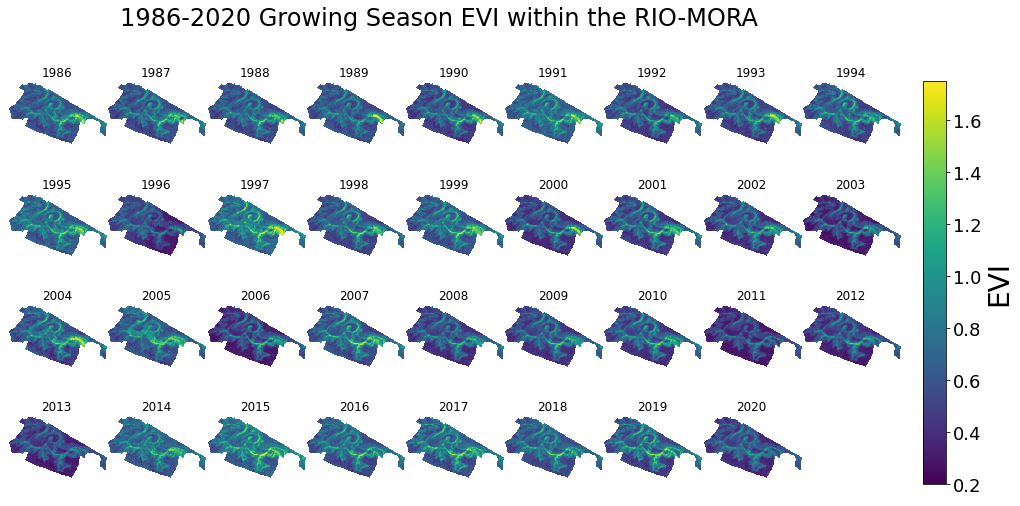

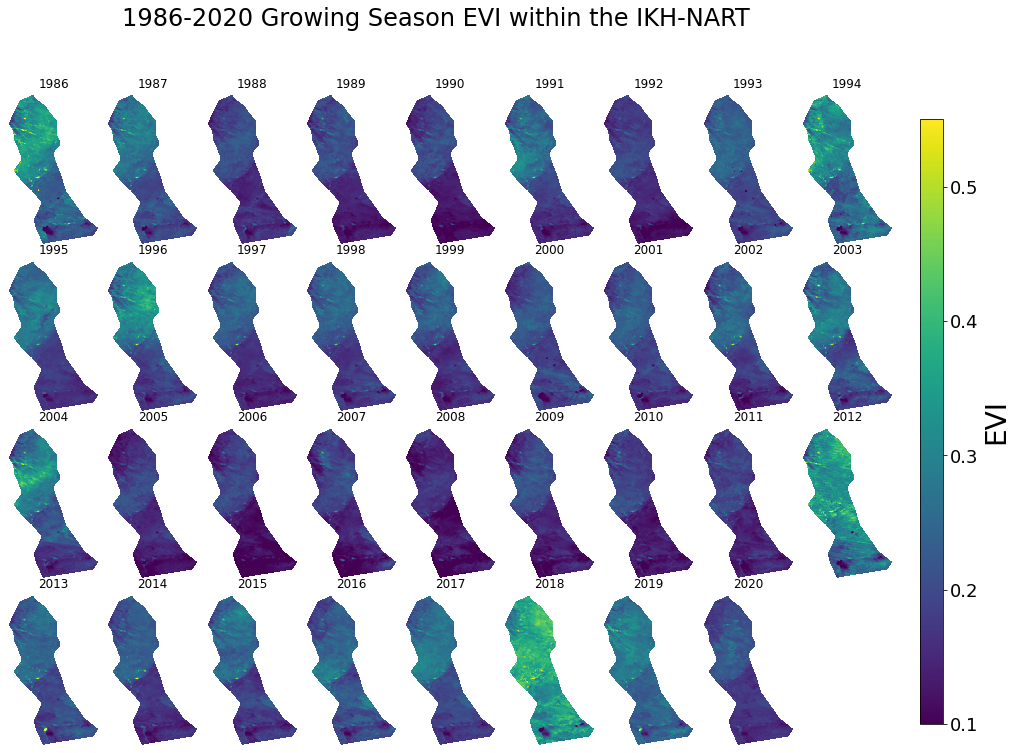

In [23]:
####VI PLOTS ONLY#####
vi = 'evi'
BUCKETS = ['rio-mora', 'ikh-nart']
for BUCKET in BUCKETS:
    if BUCKET=='ikh-nart':
        tif = rasterio.open(f'/datadrive/ikh-nart/processed/{vi}.tif')
        if vi == 'evi':
            vmin = 0.1
            vmax = 0.55 
        else:
            vmin = 0.1
            vmax = 0.35
        figsize = (16,12)
    if BUCKET=='rio-mora':
        tif = rasterio.open(f'/datadrive/rio-mora/processed/{vi}.tif')
        if vi == 'evi':
            vmin = 0.2
            vmax = 1.75 
        else:
            vmin = 0.2
            vmax = 0.65
        figsize = (16,8)
    data = tif.read()

    f,ax = plt.subplots(4,9,figsize=figsize)
    f.subplots_adjust(wspace=0, hspace=0.1)
    f.subplots_adjust(right=0.9)
    rows = np.arange(4)
    cols = np.arange(9)
    indexer = np.arange(36).reshape(4,9)
    years = np.arange(1986,2021)
    for row in rows:
        for col in cols:
            if row==3 and col==8:
                ax[row,col].axis('off')
            else:
                ax[row,col].axis('off')
                ax[row,col].set_title(years[indexer[row,col]])
                ax[row,col].imshow(data[indexer[row,col]],vmin=vmin,vmax=vmax)


    f.suptitle(f'1986-2020 Growing Season {vi.upper()} within the {BUCKET.upper()}', fontsize=24)

    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
    cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cb.ax.tick_params(labelsize=18) 
    cb.set_label(f'{vi.upper()}', fontsize=28)
    f.savefig(f'./figs/{BUCKET}_growingseason_{vi.upper()}.png',\
              dpi=200, bbox_inches='tight')
    f.show()
    #plt.close()

In [ ]:
#### TRUE COLOR PLOTS #####

BUCKETS=['ikh-nart','rio-mora']
years = np.arange(1986,2021)
for BUCKET in BUCKETS:
    if BUCKET == 'ikh-nart':
        gamma = .5 
        figsize=(16,12)
    else:
        gamma = .8 
        figsize=(16,8)
    tiffile = f'/datadrive/{BUCKET}/processed/peakcolor.tif'
    tif = rasterio.open(tiffile)

    selection =['B3','B2','B1']
    colors = [(i+1,b) for i,b in enumerate(tif.descriptions) \
              if any(s in b for s in selection)]

    scale = gamma/1800
    data = []
    for year in years:
        year_color = [(i,a) for i,a in colors if str(year) in a]
        r = tif.read(year_color[0][0]).astype(np.float)*scale
        g = tif.read(year_color[1][0]).astype(np.float)*scale
        b = tif.read(year_color[2][0]).astype(np.float)*scale
        #rgb = np.dstack((norm(r),norm(g),norm(b)))
        #rgb = np.moveaxis(np.array([norm(r),norm(g),norm(b)]),0,-1)
        rgb = np.moveaxis(np.array([r,g,b]),0,-1)
        data.append(rgb)
    data = np.array(data)
    f,ax = plt.subplots(4,9,figsize=figsize)
    f.subplots_adjust(wspace=0, hspace=0.1)
    f.subplots_adjust(right=0.9)
    rows = np.arange(4)
    cols = np.arange(9)
    indexer = np.arange(36).reshape(4,9)
    for row in rows:
        for col in cols:
            if row==3 and col==8:
                ax[row,col].axis('off')
            else:
                ax[row,col].axis('off')
                ax[row,col].set_title(years[indexer[row,col]])
                ax[row,col].imshow(data[indexer[row,col]])

    f.suptitle(f'1986-2020 True color composites of {BUCKET}', fontsize=24)
    f.savefig(f'./figs/{BUCKET}_truecolor.png', dpi=200, bbox_inches='tight')
    
    plt.close()

In [ ]:
from PIL import Image
p = Image.open('./figs/ikh-nart_truecolor.png')
p

In [ ]:
BUCKET = 'ikh-nart'
tiffile = f'/datadrive/{BUCKET}/processed/peakcolor.tif'
tif = rasterio.open(tiffile)

selection =['B3','B2','B1']
colors = [(i+1,b) for i,b in enumerate(tif.descriptions) \
      if any(s in b for s in selection)]

gamma = 1 
scale = gamma/3850.
data = []
year = 2018
#year = 1992
year_color = [(i,a) for i,a in colors if str(year) in a]
r = tif.read(year_color[0][0]).astype(np.float)*scale
g = tif.read(year_color[1][0]).astype(np.float)*scale
b = tif.read(year_color[2][0]).astype(np.float)*scale
#rgb = np.dstack((norm(r),norm(g),norm(b)))
#rgb = np.moveaxis(np.array([norm(r),norm(g),norm(b)]),0,-1)
rgb = np.moveaxis(np.array([r,g,b]),0,-1)
f,ax = plt.subplots(1,1,figsize=(8,14))
ax.imshow(rgb)

In [ ]:

def addEVI(image):
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',\
                           {'NIR': image.select('B5'),\
                            'RED': image.select('B4'),
                            'BLUE': image.select('B2')})
    return image.addBands(evi)